In [1]:
# 회귀모형 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

# 쓸데없는 알림 방지
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

#통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#머신러닝
from sklearn import datasets
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error #연속형일때 사용하는 경우 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix #범주형(분류모델)


반응변수 = Personal Loan(대출 유무) 
- 입력변수 
    - Experience : 경력
    - income : 수입
    - zip : 우편번호 
    - family : 가족 
    - CCabg : 월단위 카드 사용량 
    - education : 교육 수준
    - mortgage : 대출 
    - security account : 유가증권  계좌 유무 
    - cd account : 양도 예금증서 계좌 유무 
    - online : 온라인 계좌유무 
    - credit card : 신용카드 유무 

In [2]:
rawData = pd.read_csv('C:/Users/scien/Videos/Personal_Loan.csv')

In [3]:
rawDataFe =rawData.drop(columns=['ID', 'ZIP Code'])

In [4]:
rawDataFe = sm.add_constant(rawDataFe, has_constant='add')

In [5]:
rawDataFe

,const,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1.0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1.0,45,19,34,3,1.5,1,0,0,1,0,0,0
2,1.0,39,15,11,1,1.0,1,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,2,0,0,0,0,0,0
4,1.0,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.0,46,22,70,4,1.9,1,212,0,0,0,0,1
2496,1.0,63,37,32,3,0.7,2,141,0,0,0,0,0
2497,1.0,33,9,14,3,0.9,3,114,0,0,0,0,0
2498,1.0,38,14,111,2,6.1,1,326,0,0,0,0,0


In [6]:
y = rawDataFe['Personal Loan']
x = rawDataFe.drop(columns=['Personal Loan'])

In [13]:
train_x, test_x, train_y, test_y = train_test_split(x,y, train_size=0.7, random_state=123)

In [14]:
# static model
model = sm.Logit(train_y, train_x).fit()

Optimization terminated successfully.
         Current function value: 0.131976
         Iterations 9


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 1750
Model:                          Logit   Df Residuals:                     1738
Method:                           MLE   Df Model:                           11
Date:                Fri, 08 Jan 2021   Pseudo R-squ.:                  0.6031
Time:                        12:45:57   Log-Likelihood:                -230.96
converged:                       True   LL-Null:                       -581.97
Covariance Type:            nonrobust   LLR p-value:                1.996e-143
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.2819      2.641     -5.409      0.000     -19.457      -9.106
Age                    0.0461      0.096      0.478      0.632      -0.143       0.235
Experience            -0.0240      0.096     -0.250      0.802      -0.212       0.164
Income                 0.0508      0.004     12.207      0.000       0.043       0.059
Family                 0.6415      0.126      5.093      0.000       0.395       0.888
CCAvg                  0.1488      0.064      2.314      0.021       0.023       0.275
Education              1.5872      0.191      8.330      0.000       1.214       1.961
Mortgage               0.0001      0.001      0.158      0.874      -0.002       0.002
Securities Account    -1.5192      0.531     -2.862      0.004      -2.560      -0.479
CD Account             4.2651      0.567      7.524      0.000       3.154       5.376
Online                -0.2550      0.263     -0.970      0.332      -0.771       0.261
CreditCard            -1.4079      0.360     -3.912      0.000      -2.113      -0.703
======================================================================================
"""

0~1이 아닌 확률로 계산된 예측치 
이럴 땐 직접 컷 오프를 해야하는데...
0.05로 부여한다면 다 0으로 계산될 것임... 
- 컨퓨전 메트릭스를 만들어야해

In [21]:
pred_y = model.predict(test_x)
pd.concat([pd.DataFrame(test_y), pd.DataFrame(pred_y, columns=['Yhat'])], axis=1)

,Personal Loan,Yhat
2386,0,0.002944
1298,0,0.001620
1995,0,0.001254
2097,0,0.000705
289,0,0.000369
...,...,...
265,0,0.004077
182,0,0.015858
899,1,0.488517
1927,0,0.002706


0~1 사이로 바꿔보자 

In [37]:
def cut_off(y, threshold):
    Y = y.copy()
    Y[Y > threshold] = 1 
    
    Y[Y < threshold] = 0
    
    return (Y.astype(int))

In [34]:
pred_Y = cut_off(pred_y, 0.5)

In [35]:
pd.concat([pd.DataFrame(test_y), pd.DataFrame(pred_Y, columns=['Yhat'])], axis=1)

,Personal Loan,Yhat
2386,0,0
1298,0,0
1995,0,0
2097,0,0
289,0,0
...,...,...
265,0,0
182,0,0
899,1,0
1927,0,0


In [42]:
cmat = confusion_matrix(test_y, pred_Y)

In [41]:
# accuracy도 만들자 
def acc(cmat):
    acc=(cmat[0,0] + cmat[1,1]) / np.sum(cmat)
    return acc 

In [40]:
acc(cmat)

0.9533333333333334

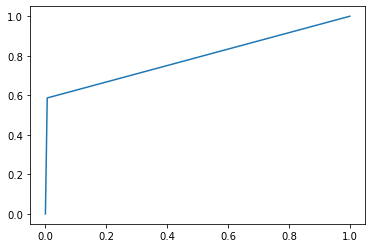

AUC: 0.7903703703703704


In [48]:
#roc curve
# _자리는 쓰레쉬홀드 자리인데 안쓸거라서 비활성화한것 
fpr, tpr, _ = metrics.roc_curve(test_y, pred_Y)
plt.plot(fpr, tpr)
plt.show()
#false positive rate와 true positive rate를 비교해 1에 가까워질수록 좋은 모델을 그린다


#auc curve 선으로 표현하는 roc에 비해 auc는 면적으로 표현  
auc = np.trapz(tpr, fpr)
print('AUC:', auc)

#### 그렇게 좋은 모델이 아니다.
일단 컬럼중에서 설득력 없는 컬럼들을 제외하고 다시 계산해보겠따.

In [52]:
y = rawDataFe['Personal Loan']
x = rawDataFe.drop(columns=['Personal Loan', 'Age', 'Experience', 'Mortgage'])

In [53]:
train_x, test_x, train_y, test_y = train_test_split(x,y, train_size=0.7, random_state=123)

In [54]:
# static model
model = sm.Logit(train_y, train_x).fit()

Optimization terminated successfully.
         Current function value: 0.133146
         Iterations 9


In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 1750
Model:                          Logit   Df Residuals:                     1741
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Jan 2021   Pseudo R-squ.:                  0.5996
Time:                        14:34:27   Log-Likelihood:                -233.01
converged:                       True   LL-Null:                       -581.97
Covariance Type:            nonrobust   LLR p-value:                2.007e-145
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.4213      0.889    -13.968      0.000     -14.164     -10.678
Income                 0.0498      0.004     12.509      0.000       0.042       0.058
Family                 0.6108      0.124      4.941      0.000       0.368       0.853
CCAvg                  0.1417      0.064      2.227      0.026       0.017       0.267
Education              1.5696      0.183      8.559      0.000       1.210       1.929
Securities Account    -1.4836      0.518     -2.863      0.004      -2.499      -0.468
CD Account             4.2873      0.561      7.639      0.000       3.187       5.387
Online                -0.2593      0.262     -0.989      0.323      -0.773       0.255
CreditCard            -1.4023      0.360     -3.892      0.000      -2.108      -0.696
======================================================================================
"""

In [58]:
pred_y = model.predict(test_x)
pred_y = cut_off(pred_y, 0.5)
cmat = confusion_matrix(pred_y, test_y)

In [61]:
acc(cmat)

0.9506666666666667

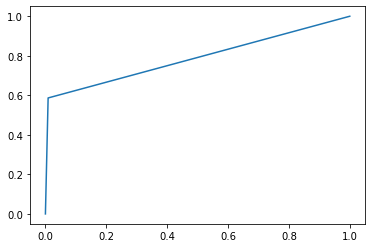

AUC: 0.7888888888888889


In [62]:
#roc curve
# _자리는 쓰레쉬홀드 자리인데 안쓸거라서 비활성화한것 
fpr, tpr, _ = metrics.roc_curve(test_y, pred_y)
plt.plot(fpr, tpr)
plt.show()
#false positive rate와 true positive rate를 비교해 1에 가까워질수록 좋은 모델을 그린다


#auc curve 선으로 표현하는 roc에 비해 auc는 면적으로 표현  
auc = np.trapz(tpr, fpr)
print('AUC:', auc)